In [24]:
from neuralforecast.utils import AirPassengersDF
from statsforecast import StatsForecast
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss
import matplotlib.pyplot as plt
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.plotting import plot_series
import fn
from toolz.functoolz import pipe
from matplotlib import cm
import matplotlib
import plotly.graph_objects as go
from ray import tune

In [40]:
# Y_df = AirPassengersDF # Defined in neuralforecast.utils
# Y_df.head()

Y_df = pipe(
  fn.loadDf("./data/TripleWitching-2024-05-06 15_56_54.csv")
  ,fn.keep(["ds","NASDAQ_Canadian_Chix_A"])
  #,lambda df:df.rename(columns={"NASDAQ_Canadian_Chix_A":"y"})
  ,fn.toLong
  ,fn.addExogenous("y")
  ,lambda df:df.fillna(0)
  #,fn.addUniqueId("1")
)
Y_df.tail(40)

# https://nixtlaverse.nixtla.io/neuralforecast/examples/exogenous_variables.html#4-forecasting-with-exogenous-variables

loadDf: ./data/TripleWitching-2024-05-06 15_56_54.csv


,ds,unique_id,y,marketOpen
2121,2024-05-04 23:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2122,2024-05-05 00:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2123,2024-05-05 01:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2124,2024-05-05 02:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2125,2024-05-05 03:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2126,2024-05-05 04:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2127,2024-05-05 05:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2128,2024-05-05 06:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2129,2024-05-05 07:00:00,NASDAQ_Canadian_Chix_A,0.0,0
2130,2024-05-05 08:00:00,NASDAQ_Canadian_Chix_A,0.0,0


In [26]:
#freq = fn.inferFreq(Y_df)
#print(freq)

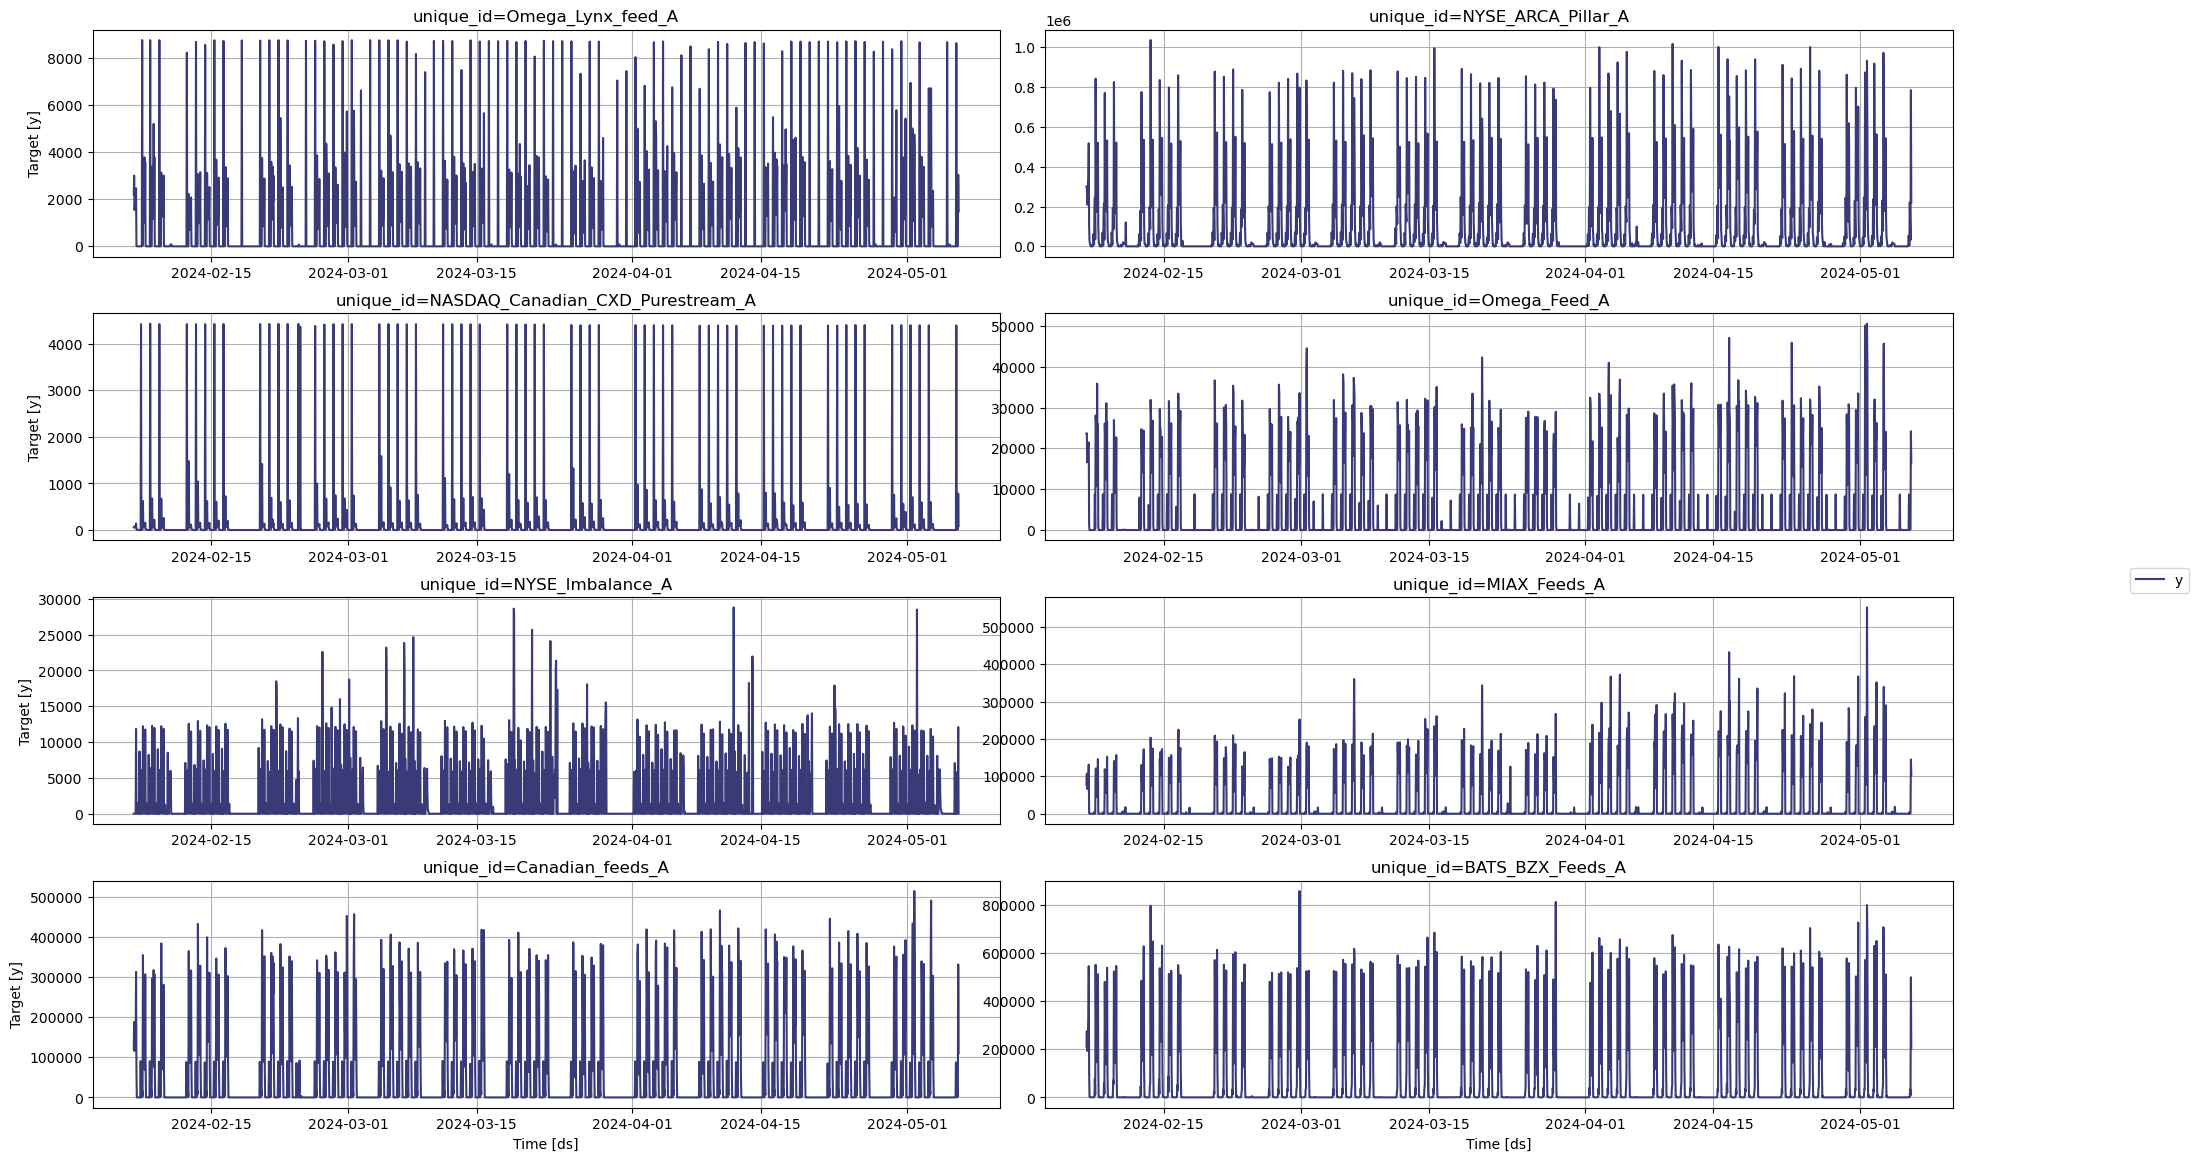

In [27]:
StatsForecast.plot(Y_df)   # , engine='matplotlib'


In [28]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [29]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=24*14, config=config_nhits, loss=MQLoss(), num_samples=5),
        # AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq='H',
     local_scaler_type='standard'
)

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.



In [30]:
nf.fit(df=Y_df)

2024-06-25 10:01:20,069	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/philip/ray_results/_train_tune_2024-06-25_09-39-29' in 0.0189s.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MQLoss        | 5     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 414 K 
-----------------------------------------------
414 K     Trainable params
5         Non-trainable params
414 K     Total params
1.657     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [31]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/utilsforecast/processing.py:374: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/utilsforecast/processing.py:428: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/neuralforecast/core.py:196: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
unique_id,,,,,,
Aeqnitch__Aequitas_NEO_A,2024-05-06 15:00:00,40488.171875,13066.667969,22780.851562,97328.812500,117461.492188
Aeqnitch__Aequitas_NEO_A,2024-05-06 16:00:00,37924.621094,5609.570312,9906.007812,91701.351562,119670.750000
Aeqnitch__Aequitas_NEO_A,2024-05-06 17:00:00,27245.292969,3714.253906,6350.761719,103349.968750,136392.531250
Aeqnitch__Aequitas_NEO_A,2024-05-06 18:00:00,22493.109375,609.218750,2494.144531,97058.539062,136410.453125
Aeqnitch__Aequitas_NEO_A,2024-05-06 19:00:00,13813.539062,1071.660156,-514.625000,79811.937500,106354.820312


/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/statsforecast/core.py:1386: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



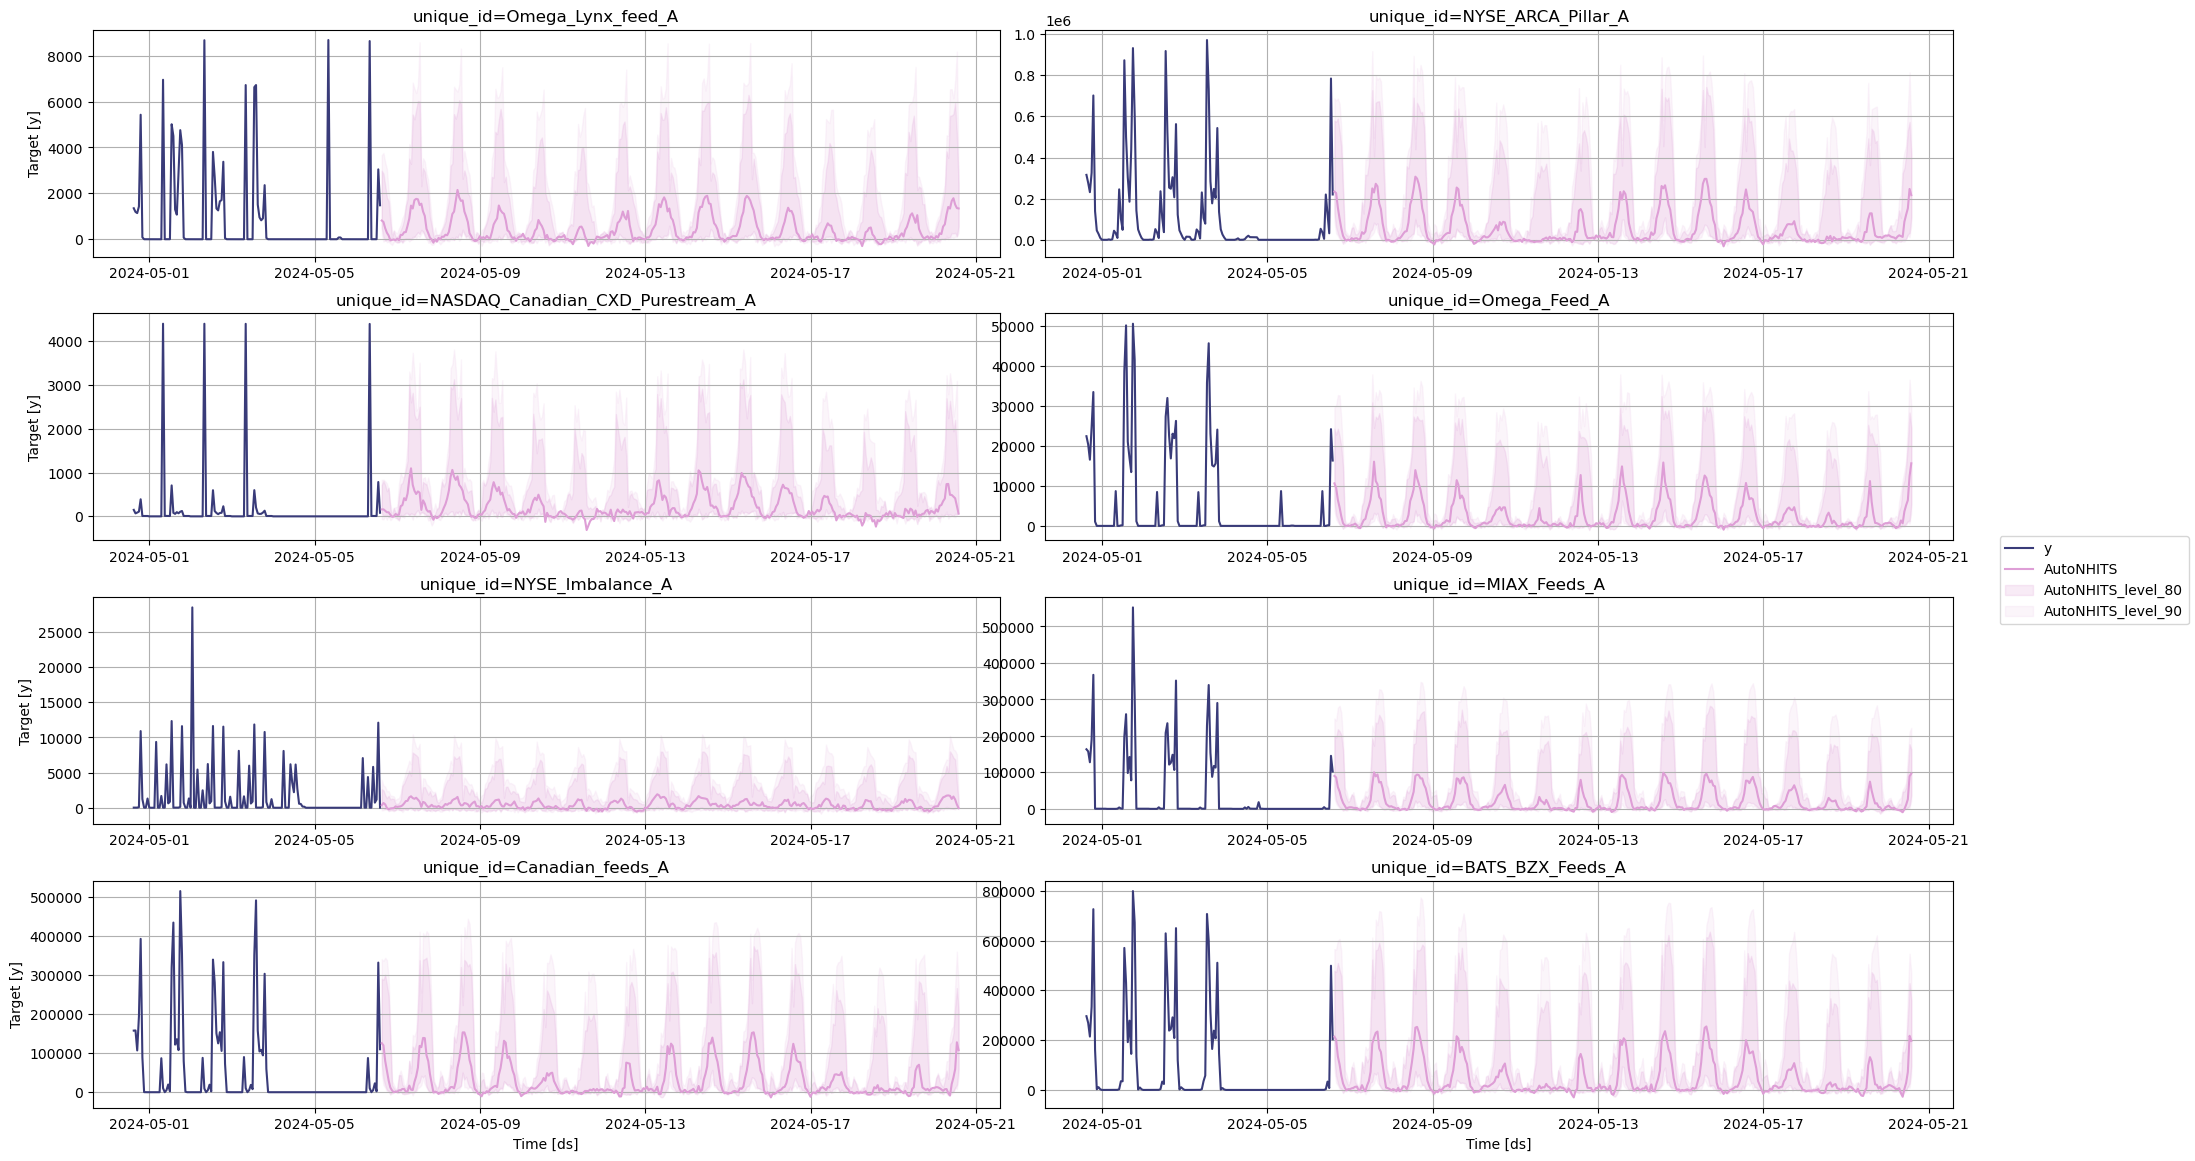

In [32]:
StatsForecast.plot(Y_df, fcst_df, engine='matplotlib', max_insample_length=48 * 3, level=[80, 90])

In [33]:
Y_hat_insample = nf.predict_insample(step_size=1)

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/utilsforecast/processing.py:374: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/philip/miniconda3/envs/prophetTest/lib/python3.11/site-packages/neuralforecast/core.py:196: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [34]:
Y_hat_insample.reset_index(inplace=True)
Y_hat_insample.columns = Y_hat_insample.columns.str.replace('-median', '')

In [35]:
Y_hat_insample

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,y
0,Aeqnitch__Aequitas_NEO_A,2024-02-06 14:00:00,2024-02-06 13:00:00,1.446795,-1.292570,-0.474882,4.885916,7.039480,70754.398438
1,Aeqnitch__Aequitas_NEO_A,2024-02-06 15:00:00,2024-02-06 13:00:00,1.224144,-1.028522,-0.225957,5.316530,7.044156,102161.601562
2,Aeqnitch__Aequitas_NEO_A,2024-02-06 16:00:00,2024-02-06 13:00:00,1.035462,-0.358060,-0.269959,4.856931,6.687856,61199.199219
3,Aeqnitch__Aequitas_NEO_A,2024-02-06 17:00:00,2024-02-06 13:00:00,0.240772,-0.487104,-0.470497,4.274836,5.282552,65658.398438
4,Aeqnitch__Aequitas_NEO_A,2024-02-06 18:00:00,2024-02-06 13:00:00,0.119904,-0.900600,-1.012270,4.965653,6.669790,81238.398438
...,...,...,...,...,...,...,...,...,...
21473755,UTP_Feed_A,2024-05-06 10:00:00,2024-04-22 14:00:00,-2162.875000,-4345.156250,-199.312500,147255.281250,179538.375000,41336.000000
21473756,UTP_Feed_A,2024-05-06 11:00:00,2024-04-22 14:00:00,33267.156250,8286.093750,2400.093750,172727.625000,209574.156250,30988.800781
21473757,UTP_Feed_A,2024-05-06 12:00:00,2024-04-22 14:00:00,76325.812500,16524.093750,10251.375000,298595.062500,427839.687500,23108.000000
21473758,UTP_Feed_A,2024-05-06 13:00:00,2024-04-22 14:00:00,268770.687500,9603.312500,30319.687500,525225.937500,609115.562500,447065.593750


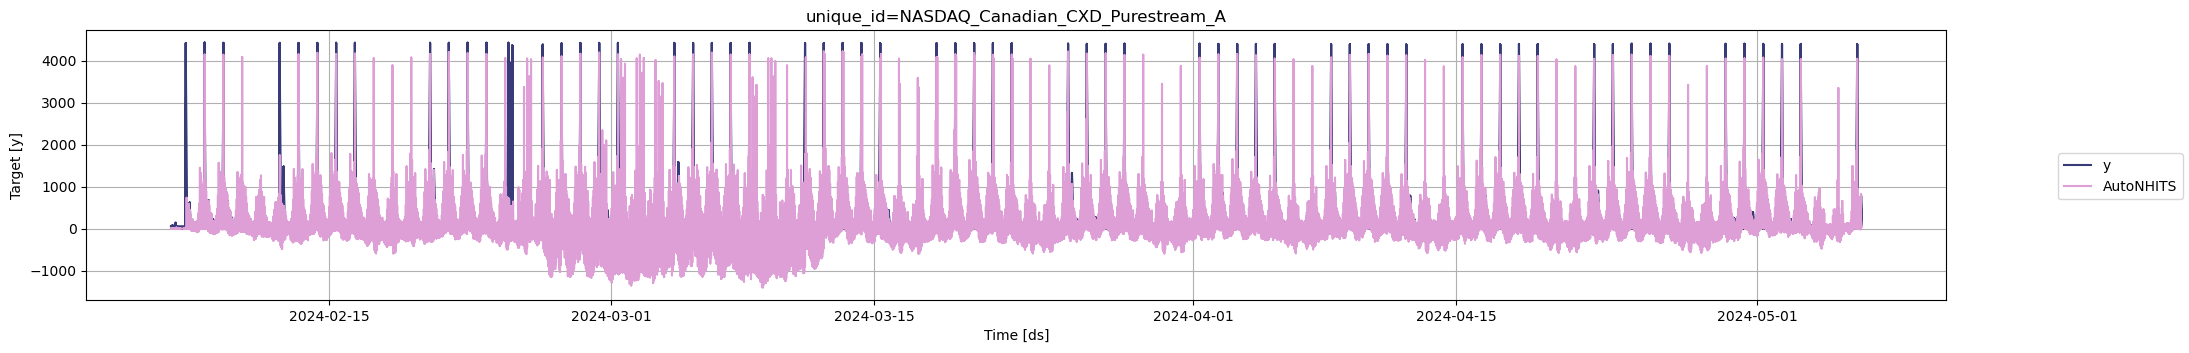

In [36]:
StatsForecast.plot(Y_df, Y_hat_insample,
  #engine='plotly', 
  #max_insample_length=48 * 3, 
  #level=[80, 90],
  unique_ids=["NASDAQ_Canadian_CXD_Purestream_A"],
  models=["AutoNHITS"]        # AutoNHITSAutoLSTM   
)